In [24]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import luminaire
from luminaire.model.window_density import WindowDensityHyperParams, WindowDensityModel
from luminaire.exploration.data_exploration import DataExploration

In [25]:
print( len(pd.date_range('2021-09-30', '2022-02-25',freq='W')))

21


In [26]:
#17
weekly_sales = [1, 12, 6, 6, 10, 11, 7, 3, 2, 4, 12, 7, 4, 4, 8, 7, 7, 6, 8, 0, 11]

data = pd.DataFrame({'index': pd.date_range('2021-10-01', '2022-02-25',freq='W'),'raw': weekly_sales}) #Each list would be added as a row
data = data.set_index('index')

data.head()

,raw
index,
2021-10-03,1
2021-10-10,12
2021-10-17,6
2021-10-24,6
2021-10-31,10


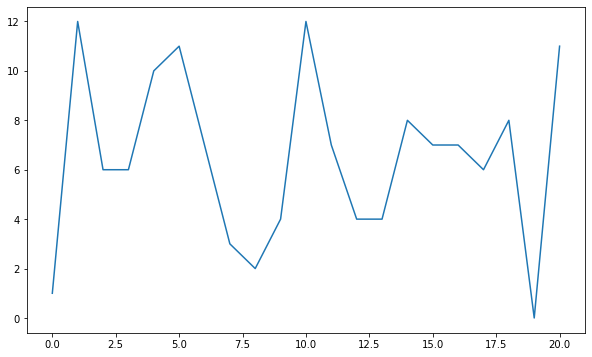

In [27]:
plt.figure(figsize=(10,6))
plt.plot(data['raw'].values)

In [31]:
def change_point_plot(data, profile_summary):
    if (profile_summary['change_point_list']):
        print(profile_summary['change_point_list'])
        change_point_list = list(profile_summary['change_point_list'])
    else:
        change_point_list=[]
        
    if profile_summary['trend_change_list']:
        trend_change_list = list(profile_summary['trend_change_list'])
    else:
        trend_change_list = []

    trendline = data[data.index.isin(trend_change_list)]

    # https://stackoverflow.com/questions/47404678/valueerror-unconverted-data-remains-000000
    plt.figure(figsize=(16,6))
    plt.plot(data['raw'], linestyle = '-')
    plt.title('The Data',fontsize=14)

    #view change points
    if change_point_list != []:
        for x in change_point_list:
            #print(x,type(x))
            x1= datetime.strptime(x,'%Y-%m-%d %H:%M:%S' )
            plt.axvline(x1,lw=2, color='red')

    #view trend changes
    if trend_change_list != []:
        for x in trend_change_list:
            #print(x,type(x))
            x1= datetime.strptime(x,'%Y-%m-%d %H:%M:%S' )
            plt.axvline(x1,lw=2, color='blue')

    #trend line
    plt.plot(trendline,lw=2, linestyle='dashed', color = 'green')
    plt.show()



In [47]:
weekly_sales = [1, 12, 6, 6, 10, 11, 7, 3, 2, 4, 12, 7, 4, 4, 8, 7, 7, 6, 8, 0, 11] 
data = pd.DataFrame({'index': pd.date_range('2021-10-01', '2022-02-25',freq='W'),'raw': weekly_sales}) #Each list would be added as a row
data = data.set_index('index')
from luminaire.optimization.hyperparameter_optimization import HyperparameterOptimization

def predict_daylumina(data):
    op = HyperparameterOptimization(freq='W')
    optimz = op.run(data=data)
    de_optimz = DataExploration(freq='W',change_point_threshold=0.5, **optimz)
    data2, data_pre_prc = de_optimz.profile(data)
    #change_point_plot(data, data_pre_prc)
    
    print(optimz['LuminaireModel'])

    if optimz['LuminaireModel']== 'LADFilteringModel':
        #If Kalman filter for anomally
        day_model_class_name = optimz['LuminaireModel']
        day_module = __import__('luminaire.model', fromlist=[''])
        day_model_class = getattr(day_module, day_model_class_name)

        day_model_object = day_model_class(hyper_params=optimz, freq='W')
        day_success, day_model_date, day_trained_model = day_model_object.train(data=data2, **data_pre_prc)


    else:
        #If Structural model for anomally 
        from luminaire.model.lad_structural import LADStructuralModel
        hyper_params = {"include_holidays_exog": False, "is_log_transformed": True, "max_ft_freq": 2, "p": 1, "q": 1}
        lad_struct_obj = LADStructuralModel(hyper_params=hyper_params, freq='W') 
        #print(lad_struct_obj)

        day_success, day_model_date, day_trained_model = lad_struct_obj.train(data=data2, **data_pre_prc)

    

    print(day_success, day_model_date, day_trained_model)

    output_pred = pd.DataFrame()
    for i in data.index:
        actual = data.loc[i,'raw']
        output = day_trained_model.score(actual, i)
        tmp = pd.DataFrame.from_dict(output[0], orient='index').T
        tmp['Actual'] = actual
        output_pred = output_pred.append(tmp)  

    output_pred['Prediction'] = output_pred['Prediction'].astype(float)
    output_pred['PredStdErr'] = output_pred['PredStdErr'].astype(float)    
    output_pred['Upper'] = output_pred['Prediction'] + 3 * output_pred['PredStdErr'] 
    output_pred['Lower'] = output_pred['Prediction'] - 3 * output_pred['PredStdErr'] 
    output_pred[output_pred['IsAnomaly']==True]
    output_pred.index = data.index
        

In [48]:
predict_daylumina(data)

100%|██████████| 50/50 [00:00<00:00, 173.54trial/s, best loss: 1e+100]
LADStructuralModel


TypeError: _training() missing 2 required positional arguments: 'ts_start' and 'ts_end'